In [ ]:
%load_ext autoreload
%autoreload 2

import sys, os
import requests
import pandas as pd
import json
import talib
import numpy as np
import time

import yfinance as yf
import warnings
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

import warnings
warnings.filterwarnings('ignore')


SECRET_FP = "./secrets.json"
with open(SECRET_FP, 'r') as file:
    secrets = json.load(file)
API_KEY = secrets['eodhd_api_key']

sys.path.append(r"C:\Users\micha\OneDrive\Documents\code\submodule")
from eodhd import  Chain, ChainHistory, Security, Index
import plot
from plot import ChartStyle
cs = ChartStyle(figsize=(20,8),nyears=1, date_fmt="%Y-%m", grid=False)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Chain

In [86]:
chain = Chain(ticker = 'SPY', max_expiration="2026-01-31")
calls = chain.calls
puts = chain.puts
atm = chain.atm
atm_calls = chain.atm_calls
atm_puts = chain.atm_puts
d25 = chain.delta_twenty_five
chain.get_atm_avg()

Total records to fetch: 5680
Fetched 1000 rows at offset 0
Fetched 1000 rows at offset 1000
Fetched 1000 rows at offset 2000
Fetched 1000 rows at offset 3000
Fetched 1000 rows at offset 4000
Fetched 680 rows at offset 5000


,exp_date,volatility_call,volatility_put,volatility_avg
0,2025-10-20,0.1562,0.1268,0.14150
1,2025-10-21,0.1714,0.1445,0.15795
2,2025-10-22,0.1775,0.1531,0.16530
3,2025-10-23,0.1818,0.1597,0.17075
4,2025-10-24,0.1943,0.1688,0.18155
5,2025-10-27,0.1733,0.1537,0.16350
6,2025-10-28,0.1755,0.1566,0.16605
7,2025-10-29,0.1840,0.1656,0.17480
8,2025-10-30,0.1892,0.1710,0.18010
9,2025-10-31,0.1939,0.1737,0.18380


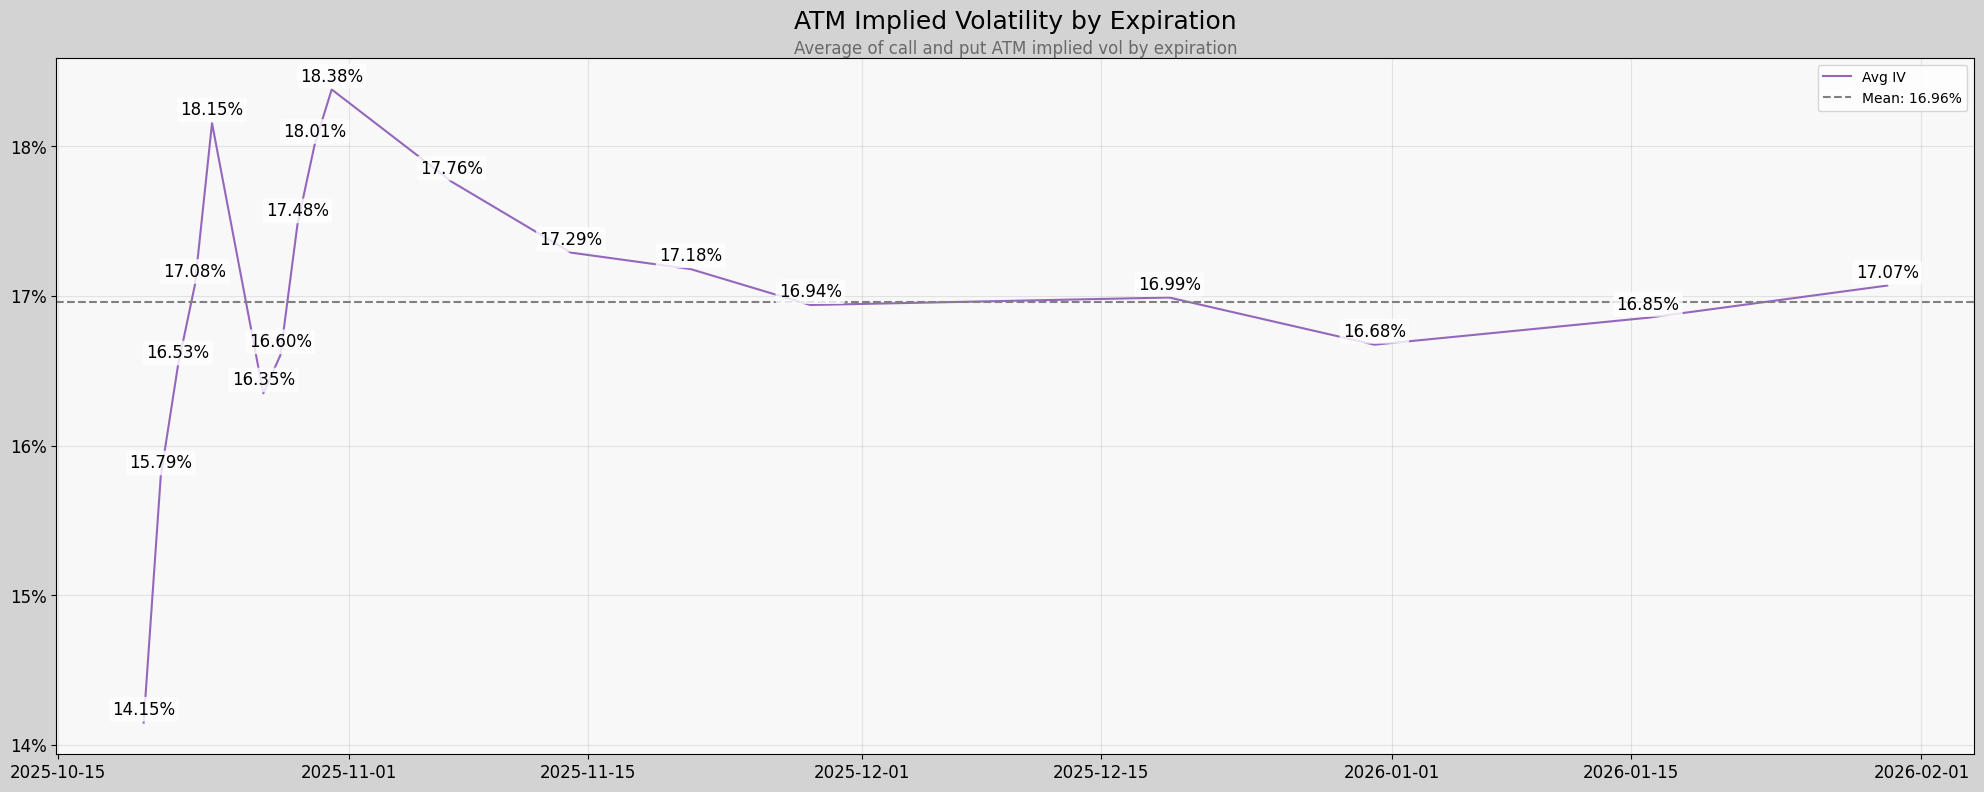

In [87]:
res = atm_calls.merge(atm_puts, on='exp_date', suffixes=('_call', '_put'), how='inner', validate='one_to_one', indicator=True)[['exp_date', 'volatility_call', 'volatility_put']]
res['ivol'] = (res['volatility_call'] + res['volatility_put']) / 2

res = atm_calls.merge(
    atm_puts,
    on='exp_date',
    suffixes=('_call', '_put'),
    how='inner',
    validate='one_to_one',
    indicator=True
)[['exp_date', 'volatility_call', 'volatility_put']].copy()
res['exp_date'] = pd.to_datetime(res['exp_date'])
res = res.sort_values('exp_date')
res['ivol'] = (res['volatility_call'] + res['volatility_put']) / 2

# single-line plot of the average (ivol)
ax = plot.plot_line(
    x=res['exp_date'],
    y=res['ivol'],
    date_axis=False,
    style=cs,
    title="ATM Implied Volatility by Expiration",
    subtitle="Average of call and put ATM implied vol by expiration",
    style_kwargs={"subtitle_size": 12},
    grid=True,
    label="Avg IV",
    annotate_last=False,
    annotate_last_fmt="{:.2%}",
    y_fmt="{:,.0%}",
    color="tab:purple",
)


for x, y in zip(res['exp_date'], res['ivol']):
    ax.annotate(f"{y:.2%}",
                xy=(x, y),
                xytext=(0, 6),
                textcoords="offset points",
                ha="center",
                fontsize=12,
                # color='tab:blue',
                zorder=4,
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.8))


ax.axhline(y=res['ivol'].mean(), color='gray', linestyle='--', label=f'Mean: {res["ivol"].mean():.2%}')
ax.legend()

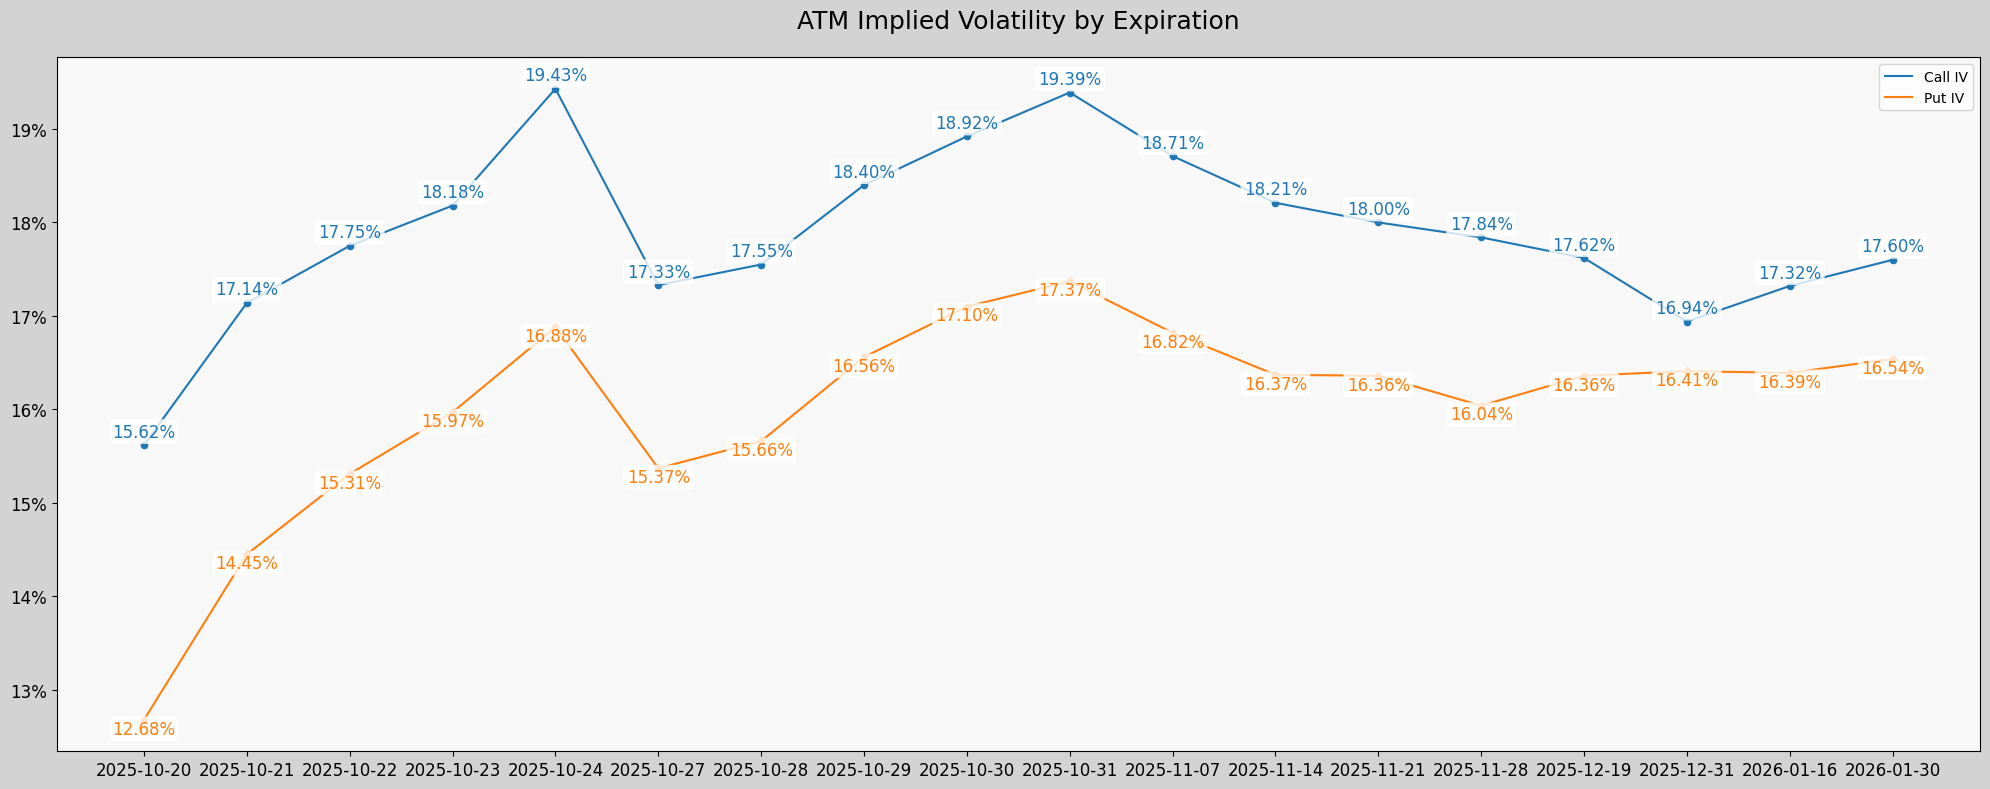

In [62]:

ax = plot.plot_line(
    x=atm_calls['exp_date'],
    y=atm_calls['volatility'],
    date_axis=False,
    style=cs,
    title="ATM Implied Volatility by Expiration",
    subtitle="",
    style_kwargs={"subtitle_size": 12},
    grid=True,
    label="Call IV",
    annotate_last=False,
    annotate_last_fmt="{:.2%}",
    y_fmt="{:,.0%}",
)

plot.plot_line(
    x=atm_puts['exp_date'],
    y=atm_puts['volatility'],
    ax=ax,
    date_axis=False,
    style=cs,
    label="Put IV",
    color="tab:orange",
    annotate_last=False,
    annotate_last_fmt="{:.2%}",
    y_fmt="{:,.0%}",
)

ax.scatter(atm_calls['exp_date'], atm_calls['volatility'], color='tab:blue', s=20, zorder=3)
ax.scatter(atm_puts['exp_date'], atm_puts['volatility'], color='tab:orange', s=20, zorder=3)

for x, y in zip(atm_calls['exp_date'], atm_calls['volatility']):
    ax.annotate(f"{y:.2%}",
                xy=(x, y),
                xytext=(0, 6),
                textcoords="offset points",
                ha="center",
                fontsize=12,
                color='tab:blue',
                zorder=4,
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.8))

for x, y in zip(atm_puts['exp_date'], atm_puts['volatility']):
    ax.annotate(f"{y:.2%}",
                xy=(x, y),
                xytext=(0, -10),
                textcoords="offset points",
                ha="center",
                fontsize=12,
                color='tab:orange',
                zorder=4,
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.8))

ax.legend()

In [63]:
chain.get_implied_move()

type,exp_date,dte,call,put,ivol,undr_last_price,expected_move_usd,expected_move_pct
0,2025-10-20,2,0.1562,0.1268,0.14150,664.39,6.959020,0.010474
1,2025-10-21,3,0.1714,0.1445,0.15795,664.39,9.513863,0.014320
2,2025-10-22,4,0.1775,0.1531,0.16530,664.39,11.496867,0.017304
3,2025-10-23,5,0.1818,0.1597,0.17075,664.39,13.277685,0.019985
4,2025-10-24,6,0.1943,0.1688,0.18155,664.39,15.464950,0.023277
5,2025-10-27,9,0.1733,0.1537,0.16350,664.39,17.057511,0.025674
6,2025-10-28,10,0.1755,0.1566,0.16605,664.39,18.260621,0.027485
7,2025-10-29,11,0.1840,0.1656,0.17480,664.39,20.161109,0.030345
8,2025-10-30,12,0.1892,0.1710,0.18010,664.39,21.696066,0.032656
9,2025-10-31,13,0.1939,0.1737,0.18380,664.39,23.045909,0.034687


In [95]:
display(puts.exp_date.sort_values().unique())
cols_display = ['contract', 'exp_date', 'strike', 'bid','ask', 'midpoint', 'last','theoretical', 'volatility','delta','gamma', 'theta', 'vega', 'rho',]
EXP_DATE = '2025-11-21'

array(['2025-10-20', '2025-10-21', '2025-10-22', '2025-10-23',
       '2025-10-24', '2025-10-27', '2025-10-28', '2025-10-29',
       '2025-10-30', '2025-10-31', '2025-11-07', '2025-11-14',
       '2025-11-21', '2025-11-28', '2025-12-19', '2025-12-31',
       '2026-01-16', '2026-01-30'], dtype=object)

In [126]:
puts_sub = puts[puts['exp_date'] == EXP_DATE].copy()[cols_display]
puts_sub = puts_sub[(puts_sub['delta'] >= -0.5) & (puts_sub['delta'] <= -0.1)]
puts_sub = puts_sub[puts_sub['strike'].notna() & np.isclose(puts_sub['strike'] % 5, 0)].copy()
puts_sub

,contract,exp_date,strike,bid,ask,midpoint,last,theoretical,volatility,delta,gamma,theta,vega,rho
1157,SPY251121P00605000,2025-11-21,605.0,2.82,2.83,2.83,2.80,2.83,0.2624,-0.106961,0.003468,-0.138253,0.373587,-0.063320
1158,SPY251121P00610000,2025-11-21,610.0,3.14,3.16,3.15,3.15,3.15,0.2542,-0.120158,0.003890,-0.145114,0.405887,-0.070876
1159,SPY251121P00615000,2025-11-21,615.0,3.52,3.54,3.53,3.52,3.52,0.2460,-0.135227,0.004366,-0.151961,0.440590,-0.079274
1160,SPY251121P00620000,2025-11-21,620.0,3.95,3.97,3.96,3.93,3.96,0.2381,-0.152782,0.004900,-0.159127,0.478386,-0.089265
1161,SPY251121P00625000,2025-11-21,625.0,4.46,4.48,4.47,4.42,4.47,0.2302,-0.172947,0.005494,-0.166120,0.518552,-0.100760
1162,SPY251121P00630000,2025-11-21,630.0,5.03,5.05,5.04,5.02,5.04,0.2220,-0.195749,0.006157,-0.172235,0.560049,-0.113346
1165,SPY251121P00635000,2025-11-21,635.0,5.70,5.72,5.71,5.69,5.71,0.2140,-0.222089,0.006885,-0.177845,0.603258,-0.127851
1168,SPY251121P00640000,2025-11-21,640.0,6.47,6.50,6.48,6.43,6.49,0.2058,-0.252281,0.007681,-0.182376,0.646905,-0.143772
1169,SPY251121P00645000,2025-11-21,645.0,7.35,7.38,7.37,7.37,7.37,0.1975,-0.286757,0.008549,-0.185183,0.689555,-0.160961
1170,SPY251121P00650000,2025-11-21,650.0,8.36,8.39,8.38,8.38,8.38,0.1887,-0.325862,0.009473,-0.185522,0.729618,-0.181571


In [127]:
puts_sub[puts_sub['strike']==640]

,contract,exp_date,strike,bid,ask,midpoint,last,theoretical,volatility,delta,gamma,theta,vega,rho
1168,SPY251121P00640000,2025-11-21,640.0,6.47,6.5,6.48,6.43,6.49,0.2058,-0.252281,0.007681,-0.182376,0.646905,-0.143772


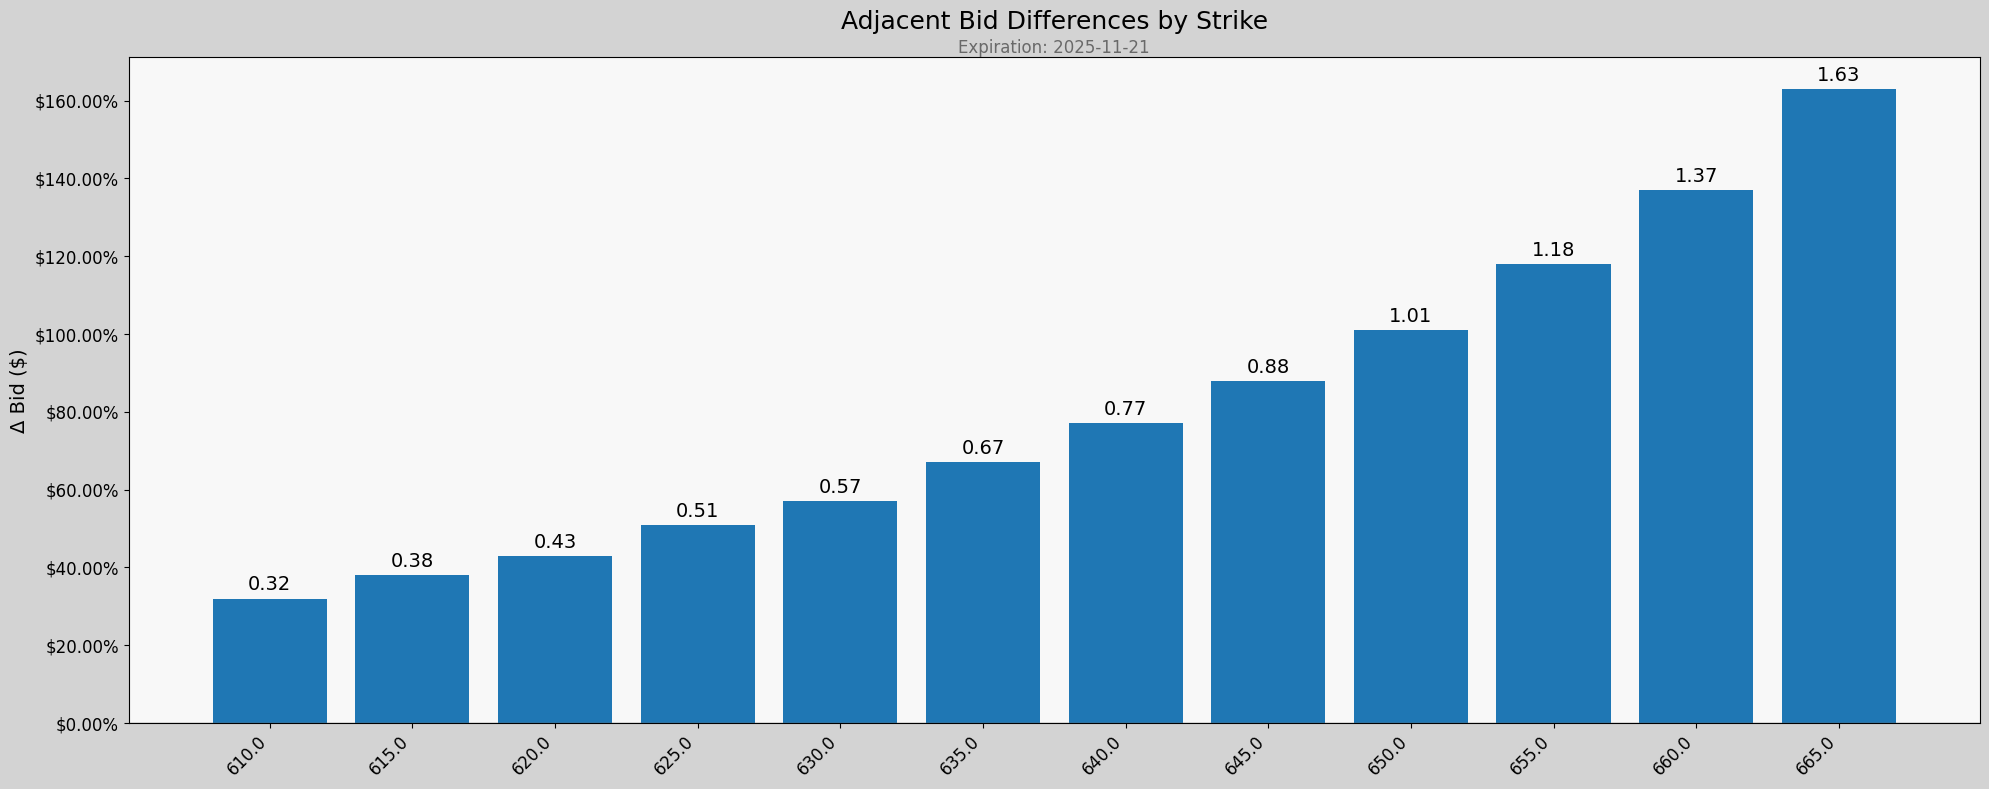

In [133]:
VAR = 'bid'
# ensure numeric and one row per strike
_tmp = puts_sub.copy()
_tmp['strike'] = pd.to_numeric(_tmp['strike'], errors='coerce')
_tmp[VAR] = pd.to_numeric(_tmp[VAR], errors='coerce')
bid_by_strike = (
    _tmp.dropna(subset=['strike', VAR])
        .sort_values('strike')
        .groupby('strike', as_index=True)[VAR].max()
)

# adjacent differences (current strike bid - previous strike bid)
diffs = bid_by_strike.diff().dropna()
diffs

from matplotlib.ticker import FuncFormatter

ax = plot.plot_bar(
    x=diffs.index.astype(str),
    y=diffs.values,
    style=cs,
    title=f"Adjacent {VAR.capitalize()} Differences by Strike",
    annotate=True,
    ylabel=f"Δ {VAR.capitalize()} ($)",
    subtitle=f"Expiration: {EXP_DATE}"
)

ax.axhline(0, color='gray', lw=1)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'${y:,.2%}'))
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout(); plt.show()

In [ ]:
import numpy as np
import pandas as pd
from math import erf, log, sqrt

def _std_norm_cdf(x: np.ndarray) -> np.ndarray:
    """Standard normal CDF using erf (no external deps)."""
    return 0.5 * (1.0 + np.vectorize(erf)(x / sqrt(2.0)))

def all_put_credit_spreads_no_rename(puts_df: pd.DataFrame,
                                     min_oi: int = 0,
                                     min_vol: int = 0,
                                     underlying_price: float | None = None,
                                     assume_sigma: float = 0.25) -> pd.DataFrame:
    """
    Build all bull-put credit spreads from puts_df (same expiration) and compute
    return-on-risk plus comparison metrics (net delta, estimated profit probability,
    expected value per spread). Keeps original column names (suffixes added by self-merge).
    - underlying_price: if provided used to estimate profit probability; otherwise attempts
      to use columns 'underlying_price' or global `sec.last_close` (if present).
    - assume_sigma: fallback implied vol used if option volatility columns missing.
    """
    df = puts_df.copy()
    # ensure numeric
    for c in ['strike','bid','ask','last','theoretical','open_interest','volume','delta','volatility']:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')

    # liquidity filters
    if 'open_interest' in df.columns:
        df = df[df['open_interest'].fillna(0) >= min_oi]
    if 'volume' in df.columns:
        df = df[df['volume'].fillna(0) >= min_vol]
    if df.empty:
        return pd.DataFrame()

    # mid price: bid/ask -> last -> theoretical
    if {'bid','ask'}.issubset(df.columns):
        df['mid'] = (df['bid'].fillna(0) + df['ask'].fillna(0)) / 2.0
        zero_mid = df['mid'].eq(0)
        if 'last' in df.columns:
            df.loc[zero_mid & df['last'].notna(), 'mid'] = df.loc[zero_mid, 'last']
        if 'theoretical' in df.columns:
            df.loc[df['mid'].isna() & df['theoretical'].notna(), 'mid'] = df.loc[df['mid'].isna(), 'theoretical']
    else:
        src = 'last' if 'last' in df.columns else ('theoretical' if 'theoretical' in df.columns else None)
        df['mid'] = df[src] if src else np.nan

    # cross-join on expiration using self-merge; keep suffixes to distinguish legs
    m = df.merge(df, on='exp_date', suffixes=('_short','_long'), validate='many_to_many')

    # keep credit-put orientation: short (higher strike) > long (lower strike)
    m = m[m['strike_short'] > m['strike_long']].copy()
    if m.empty:
        return pd.DataFrame()

    # economics
    m['width'] = m['strike_short'] - m['strike_long']
    m['credit'] = (m['mid_short'] - m['mid_long']).clip(lower=0)
    m = m[m['credit'] > 0].copy()
    if m.empty:
        return pd.DataFrame()

    m['max_profit'] = m['credit']
    m['max_loss'] = (m['width'] - m['credit']).clip(lower=0)
    m = m[m['max_loss'] > 0].copy()
    if m.empty:
        return pd.DataFrame()

    m['breakeven'] = m['strike_short'] - m['credit']

    # net delta (if delta columns exist)
    if 'delta_short' in m.columns or 'delta_long' in m.columns:
        m['delta_short'] = m.get('delta_short', 0.0).astype(float)
        m['delta_long']  = m.get('delta_long', 0.0).astype(float)
        m['net_delta'] = m['delta_short'] + m['delta_long']
    else:
        m['net_delta'] = np.nan

    # attempt to determine underlying price
    S = None
    if underlying_price is not None:
        S = float(underlying_price)
    else:
        if 'underlying_price' in df.columns:
            S = float(df['underlying_price'].dropna().iloc[0])
        else:
            # try to use a globally defined `sec` object if present
            try:
                S = float(sec.last_close)  # sec from earlier cell
            except Exception:
                S = None

    # estimate sigma: prefer volatility_short then avg of both then fallback
    if 'volatility_short' in m.columns:
        sigma = m['volatility_short'].astype(float).replace(0, np.nan)
    else:
        vs = []
        if 'volatility_short' in m.columns: vs.append(m['volatility_short'])
        if 'volatility_long' in m.columns:  vs.append(m['volatility_long'])
        if vs:
            sigma = pd.concat(vs, axis=1).mean(axis=1)
        else:
            sigma = np.nan

    # compute probability of profit and expected value per spread
    today = pd.Timestamp.today().normalize()
    prob_list = []
    ev_list = []
    sigma_arr = []
    for idx, row in m.iterrows():
        BE = row['breakeven']
        max_loss = row['max_loss']
        credit = row['credit']

        # time to expiry in years
        try:
            exp = pd.to_datetime(row['exp_date'])
            days = max((exp.normalize() - today).days, 0)
            T = days / 365.0 if days > 0 else 0.0
        except Exception:
            T = 0.0

        # sigma for this pair
        s = np.nan
        if 'volatility_short' in m.columns and not np.isnan(row.get('volatility_short', np.nan)):
            s = float(row['volatility_short'])
        elif 'volatility_long' in m.columns and not np.isnan(row.get('volatility_long', np.nan)):
            s = float(row['volatility_long'])
        elif not np.isnan(sigma):
            s = float(sigma.loc[idx]) if isinstance(sigma, pd.Series) else float(sigma)
        else:
            s = float(assume_sigma)
        sigma_arr.append(s)

        if S is None or T <= 0 or s <= 0:
            # fallback: use deltas as heuristic for profit prob if present
            if 'delta_short' in row and not pd.isna(row['delta_short']):
                # approximate profit probability as 1 - |short_delta| (heuristic)
                prob = 1.0 - abs(float(row['delta_short']))
            else:
                prob = np.nan
        else:
            # Using lognormal approx with r=0: P(S_T > BE) = 1 - Phi( z )
            # where z = (ln(BE/S) + 0.5*s^2*T) / (s*sqrt(T))
            try:
                z = (log(BE / S) + 0.5 * (s**2) * T) / (s * sqrt(T))
                prob = 1.0 - _std_norm_cdf(z)
            except Exception:
                prob = np.nan

        prob_list.append(prob)
        # expected value per contract (USD): win -> receive credit, lose -> pay max_loss (approx)
        if pd.isna(prob):
            ev = np.nan
        else:
            ev = prob * credit - (1.0 - prob) * max_loss
        ev_list.append(ev)

    m['est_sigma'] = sigma_arr
    m['prob_profit'] = prob_list
    m['expected_value'] = ev_list
    # risk/return metrics
    m['risk_return'] = m['max_loss'] / m['max_profit']      # lower is better
    m['return_on_risk'] = m['max_profit'] / m['max_loss']  # reward per unit risk
    # m['credit_per_risk'] = m['credit'] / m['max_loss']

    # s['credit_pct'] = s['cons_credit'] / s['width']            # credit as fraction of width
    # s['ev_per_risk'] = s['expected_value'] / s['max_loss']    # may be negative
    # s['ev_per_capital'] = s['expected_value'] / s['cons_max_loss']  # expected $ / $ risk
    # s['prob_profit'] = pd.to_numeric(s.get('prob_profit'), errors='coerce').fillna(0)
    # s['return_on_risk'] = pd.to_numeric(s.get('return_on_risk'), errors='coerce').fillna(0)
    # s['net_delta'] = pd.to_numeric(s.get('net_delta'), errors='coerce')
    # s['score'] = (
    #       s['prob_profit'] * 100.0           # reward high probability
    #     + s['return_on_risk'] * 50.0         # reward good return per risk
    #     + s['credit_pct'] * 200.0            # reward getting large fraction of width as credit
    #     - (s['cons_max_loss'] / 100.0)        # penalize large absolute max loss
    #     - s['net_delta'].abs() * 10.0        # prefer lower directional exposure
    # )

    # # filters you might use (example)
    # f = (
    #     (s['cons_credit'] > 0) &
    #     (s['cons_max_loss'] > 0) &
    #     (s['prob_profit'] >= 0.60) &        # at least 60% chance to keep credit
    #     (s['credit_pct'] >= 0.05) &         # credit at least 5% of width
    #     (s['cons_max_loss'] <= 2000) &      # limit absolute risk (adjust)
    #     (s['net_delta'].abs() <= 0.35)      # remove overly directional trades
    # )


    # select useful columns (original columns kept with suffixes)
    cols = [
        'exp_date',
        'strike_short','bid_short','delta_short','volatility_short',
        'strike_long','ask_long','delta_long','volatility_long',
        'width','credit','max_profit','max_loss','breakeven','net_delta',
        'prob_profit','expected_value','est_sigma','return_on_risk','risk_return'
    ]
    cols = [c for c in cols if c in m.columns]
    out = m[cols].reset_index(drop=True).sort_values(['expected_value','return_on_risk'], ascending=[False, True])
    return out

# usage: compute and display
spreads = all_put_credit_spreads_no_rename(puts_sub, min_oi=0, min_vol=0)
display(spreads.head(50).sort_values('return_on_risk', ascending=False))
# ...existing code...


,exp_date,strike_short,bid_short,delta_short,volatility_short,strike_long,ask_long,delta_long,volatility_long,width,credit,max_profit,max_loss,breakeven,net_delta,prob_profit,expected_value,est_sigma,return_on_risk,risk_return
77,2025-11-21,665.0,12.54,-0.480557,0.1617,660.0,10.95,-0.422204,0.1707,5.0,1.635,1.635,3.365,663.365,-0.902761,0.519443,-0.767785,0.1617,0.485884,2.058104
76,2025-11-21,665.0,12.54,-0.480557,0.1617,655.0,9.57,-0.370701,0.1799,10.0,3.010,3.010,6.990,661.990,-0.851258,0.519443,-1.795570,0.1617,0.430615,2.322259
75,2025-11-21,665.0,12.54,-0.480557,0.1617,650.0,8.39,-0.325862,0.1887,15.0,4.190,4.190,10.810,660.810,-0.806419,0.519443,-3.018355,0.1617,0.387604,2.579952
65,2025-11-21,660.0,10.91,-0.422204,0.1707,655.0,9.57,-0.370701,0.1799,5.0,1.375,1.375,3.625,658.625,-0.792905,0.577796,-0.736020,0.1707,0.379310,2.636364
74,2025-11-21,665.0,12.54,-0.480557,0.1617,645.0,7.38,-0.286757,0.1975,20.0,5.200,5.200,14.800,659.800,-0.767314,0.519443,-4.411140,0.1617,0.351351,2.846154
64,2025-11-21,660.0,10.91,-0.422204,0.1707,650.0,8.39,-0.325862,0.1887,10.0,2.555,2.555,7.445,657.445,-0.748066,0.577796,-1.667040,0.1707,0.343183,2.913894
63,2025-11-21,660.0,10.91,-0.422204,0.1707,645.0,7.38,-0.286757,0.1975,15.0,3.565,3.565,11.435,656.435,-0.708961,0.577796,-2.768060,0.1707,0.311762,3.207574
54,2025-11-21,655.0,9.54,-0.370701,0.1799,650.0,8.39,-0.325862,0.1887,5.0,1.180,1.180,3.820,653.820,-0.696563,0.629299,-0.673505,0.1799,0.308901,3.237288
62,2025-11-21,660.0,10.91,-0.422204,0.1707,640.0,6.50,-0.252281,0.2058,20.0,4.445,4.445,15.555,655.555,-0.674485,0.577796,-3.999080,0.1707,0.285760,3.499438
53,2025-11-21,655.0,9.54,-0.370701,0.1799,645.0,7.38,-0.286757,0.1975,10.0,2.190,2.190,7.810,652.810,-0.657458,0.629299,-1.517010,0.1799,0.280410,3.566210


<Axes: xlabel='credit', ylabel='expected_value'>

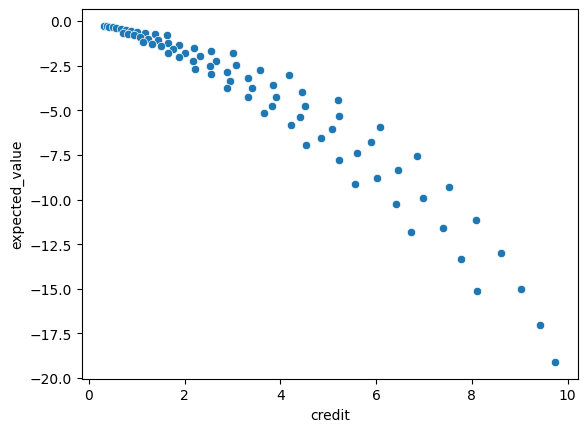

In [144]:
sns.scatterplot(data=spreads, x='credit', y='expected_value')

# Chain History

In [65]:
ch = ChainHistory(ticker="SPY", start="2024-09-05", end="2025-10-17", chunk_size=15, refresh=False)
hist = ch.history
trd = ch.trades

hist_atm = ch.get_timeseries_by_delta(delta_target=0.5, delta_tolerance=0.1, trades=True) 
dte_30 = ch.get_n_dte_timeseries(n_days=30, trades=True)
delta_25_dte_30 = ch.get_time_series_n_dte_by_delta(n_days=30, delta_target=0.25, delta_tolerance=0.1, trades=True)

pcs = ch.get_pc_spread(df=delta_25_dte_30, value='volatility')
pcs_rank = ch.get_pc_spread_rank(df=pcs)
pcs_rolling = ch.get_pc_spread_rolling(df=pcs, window=20)

ivol_rank = ch.get_ivol_rank(df=pcs)

iv_rank, vw_iv_percentile = ch.get_iv_rank(df=hist_atm)
iv_rank_roll = ch.get_iv_rank_rolling(df=hist_atm, window=20)

No existing data found. Fetching new data for SPY from 2024-09-05 to 2025-10-17
Fetching history from 2024-09-05 to 2024-09-20
Total records to fetch: 126166
Fetched 1000 rows at offset 0
Fetched 1000 rows at offset 1000
Fetched 1000 rows at offset 2000
Fetched 1000 rows at offset 3000
Fetched 1000 rows at offset 4000
Fetched 1000 rows at offset 5000
Fetched 1000 rows at offset 6000
Fetched 1000 rows at offset 7000
Fetched 1000 rows at offset 8000
Fetched 1000 rows at offset 9000
Reached limit at offset 10000, continuing with new request...
Fetched 1000 rows at offset 10000
No rows returned at offset 11000, breaking current batch
No more data available, stopping pagination at offset 11000
Fetching history from 2024-09-21 to 2024-10-06
Total records to fetch: 119798
Fetched 1000 rows at offset 0
Fetched 1000 rows at offset 1000
Fetched 1000 rows at offset 2000
Fetched 1000 rows at offset 3000
Fetched 1000 rows at offset 4000
Fetched 1000 rows at offset 5000
Fetched 1000 rows at offset 6

In [66]:
cols_view = ['tradetime', 'contract', 'underlying_symbol', 'expiration_type', 'exp_date',  'type', 'strike','dte', 'delta', 'volatility',  'volume']
cols_greeks = ['delta', 'gamma', 'theta', 'vega', 'rho']
cols_trade = [ 'open', 'high', 'low', 'last', 'last_size', 'change', 'pctchange', 'previous', 'previous_date', 'bid', 'bid_date', 'bid_size', 'ask', 'ask_date', 'ask_size','moneyness', 
              'volume', 'volume_change', 'volume_pctchange', 'open_interest','open_interest_change', 'open_interest_pctchange', 'theoretical', 'vol_oi_ratio']

In [67]:
ch.history

,contract,underlying_symbol,exp_date,expiration_type,type,strike,exchange,currency,open,high,...,theoretical,delta,gamma,theta,vega,rho,tradetime,vol_oi_ratio,dte,midpoint
0,SPY270115C00595000,SPY,2027-01-15,monthly,call,595,AMEX,USD,0.0,0.0,...,74.91,0.622057,0.002415,-0.058460,0.999999,0.999999,2024-09-18,0.0,823.0,74.91
1,SPY270115C00595000,SPY,2027-01-15,monthly,call,595,AMEX,USD,0.0,0.0,...,71.43,0.612018,0.002491,-0.057750,0.999999,0.999999,2024-09-18,0.0,825.0,71.43
2,SPY270115C00595000,SPY,2027-01-15,monthly,call,595,AMEX,USD,0.0,0.0,...,69.73,0.603322,0.002506,-0.057436,0.999999,0.999999,2024-09-18,0.0,827.0,69.73
3,SPY270115C00595000,SPY,2027-01-15,monthly,call,595,AMEX,USD,0.0,0.0,...,70.32,0.603999,0.002486,-0.057213,0.999999,0.999999,2024-09-18,0.0,828.0,70.32
4,SPY270115C00595000,SPY,2027-01-15,monthly,call,595,AMEX,USD,0.0,0.0,...,68.02,0.593935,0.002517,-0.056727,0.999999,0.999999,2024-09-18,0.0,829.0,68.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285995,SPY260130P00642000,SPY,2026-01-30,weekly,put,642,AMEX,USD,0.0,0.0,...,14.79,-0.323269,0.005421,-0.099189,0.999999,-0.550496,2025-10-14,0.0,104.0,14.79
285996,SPY260130P00685000,SPY,2026-01-30,weekly,put,685,AMEX,USD,0.0,0.0,...,29.97,-0.620880,0.007636,-0.068322,0.999999,-0.844584,2025-10-14,0.0,104.0,29.97
285997,SPY260130C00490000,SPY,2026-01-30,weekly,call,490,AMEX,USD,0.0,0.0,...,181.59,0.941428,0.000801,-0.106398,0.397685,0.999999,2025-10-15,0.0,104.0,181.59
285998,SPY260130C00565000,SPY,2026-01-30,weekly,call,565,AMEX,USD,0.0,0.0,...,110.43,0.876734,0.001933,-0.135013,0.710042,0.999999,2025-10-15,0.0,104.0,110.43


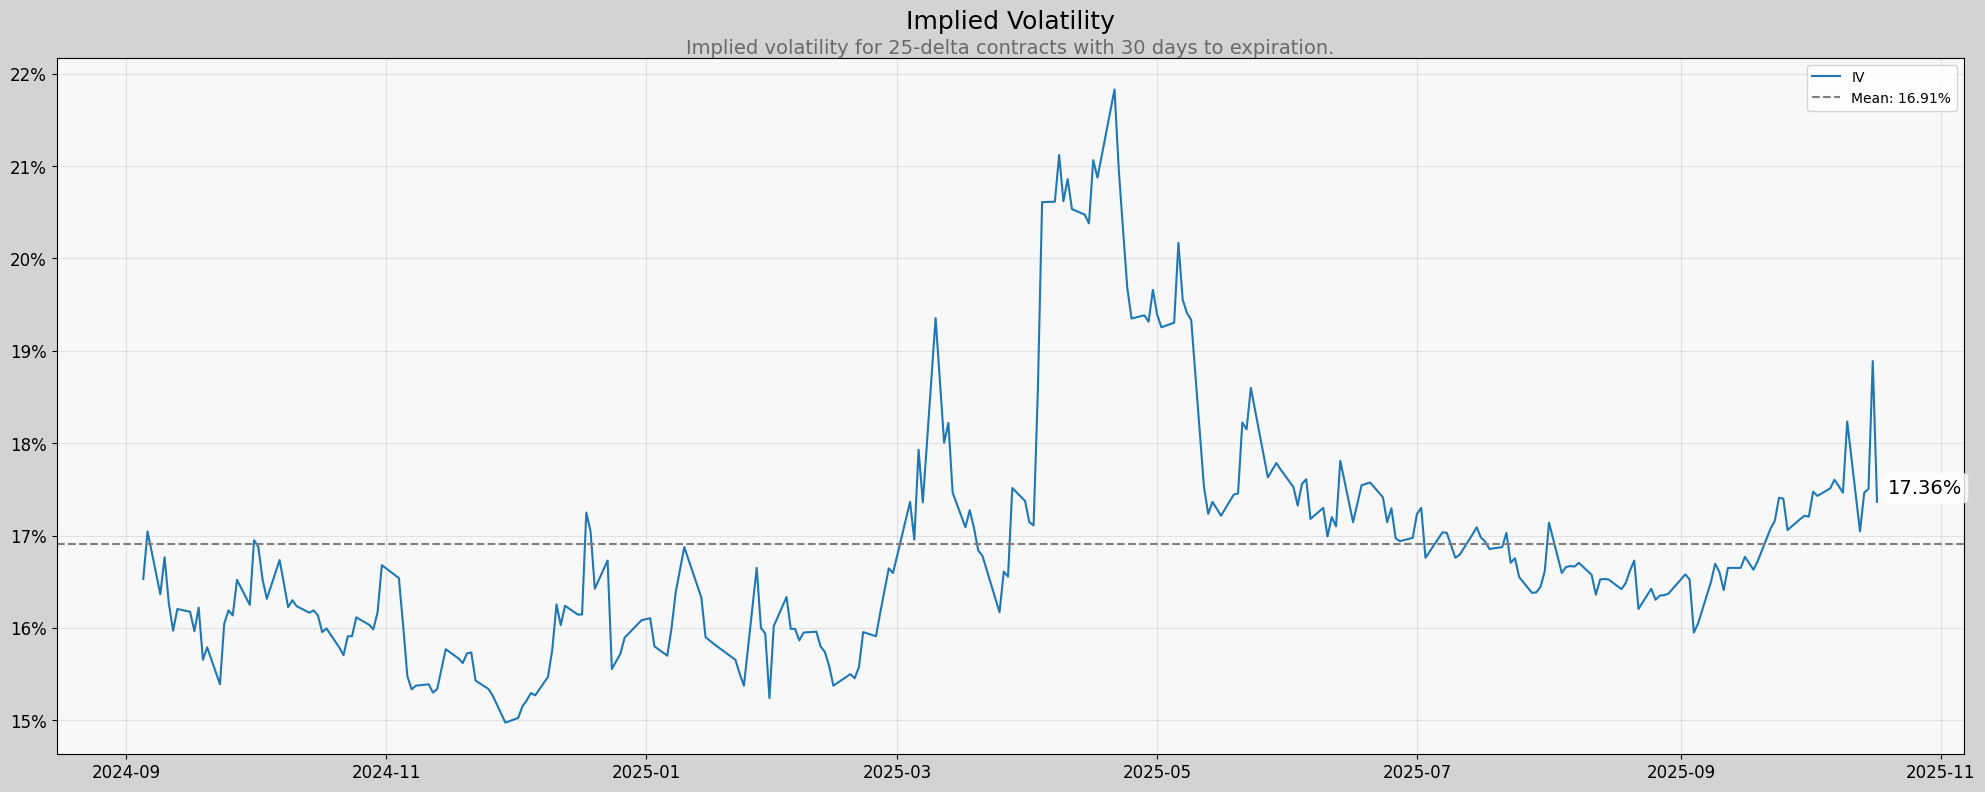

In [68]:
ax = plot.plot_line(
    x=pcs['tradetime'],
    y=pcs['ivol'],
    date_axis=False,
    style=cs,
    title="Implied Volatility",
    subtitle="Implied volatility for 25-delta contracts with 30 days to expiration.",
    style_kwargs={"subtitle_size": 14},
    grid=True,
    label="IV",
    annotate_last=True,
    annotate_last_fmt="{:.2%}",
    y_fmt="{:,.0%}",
)
ax.axhline(y=pcs['ivol'].mean(), color='gray', linestyle='--', label=f'Mean: {pcs["ivol"].mean():.2%}')
import matplotlib.pyplot as plt
plt.legend()

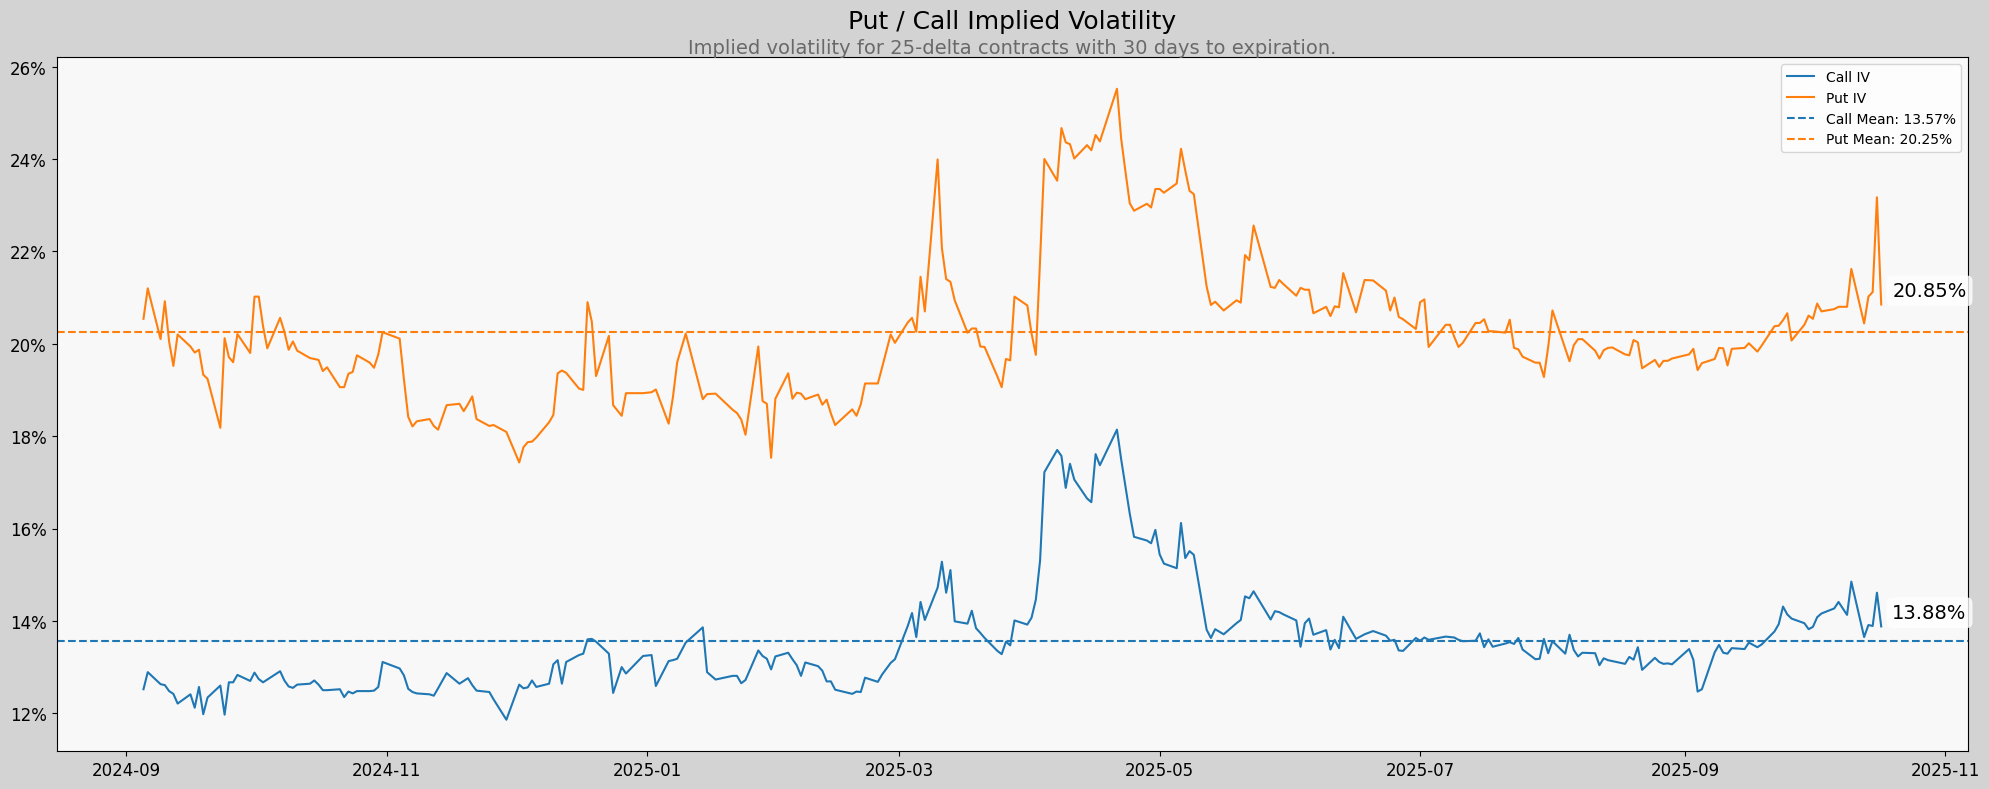

In [69]:
ax = plot.plot_line(
    x=pcs['tradetime'],
    y=pcs['call_vol'],
    date_axis=False,
    style=cs,
    title="Put / Call Implied Volatility",
    subtitle="Implied volatility for 25-delta contracts with 30 days to expiration.",
    style_kwargs={"subtitle_size": 14},
    grid=True,
    label="Call IV",
    annotate_last=True,
    annotate_last_fmt="{:.2%}",
    y_fmt="{:,.0%}",
)
plot.plot_line(
    x=pcs['tradetime'],
    y=pcs['put_vol'],
    ax=ax,
    date_axis=False,
    style=cs,
    label="Put IV",
    annotate_last=True,
    annotate_last_fmt="{:.2%}",
    y_fmt="{:,.0%}",
    color="tab:orange",
)
ax.axhline(y=pcs['call_vol'].mean(), color='tab:blue', linestyle='--', label=f'Call Mean: {pcs["call_vol"].mean():.2%}')
ax.axhline(y=pcs['put_vol'].mean(), color='tab:orange', linestyle='--', label=f'Put Mean: {pcs["put_vol"].mean():.2%}')
ax.legend()

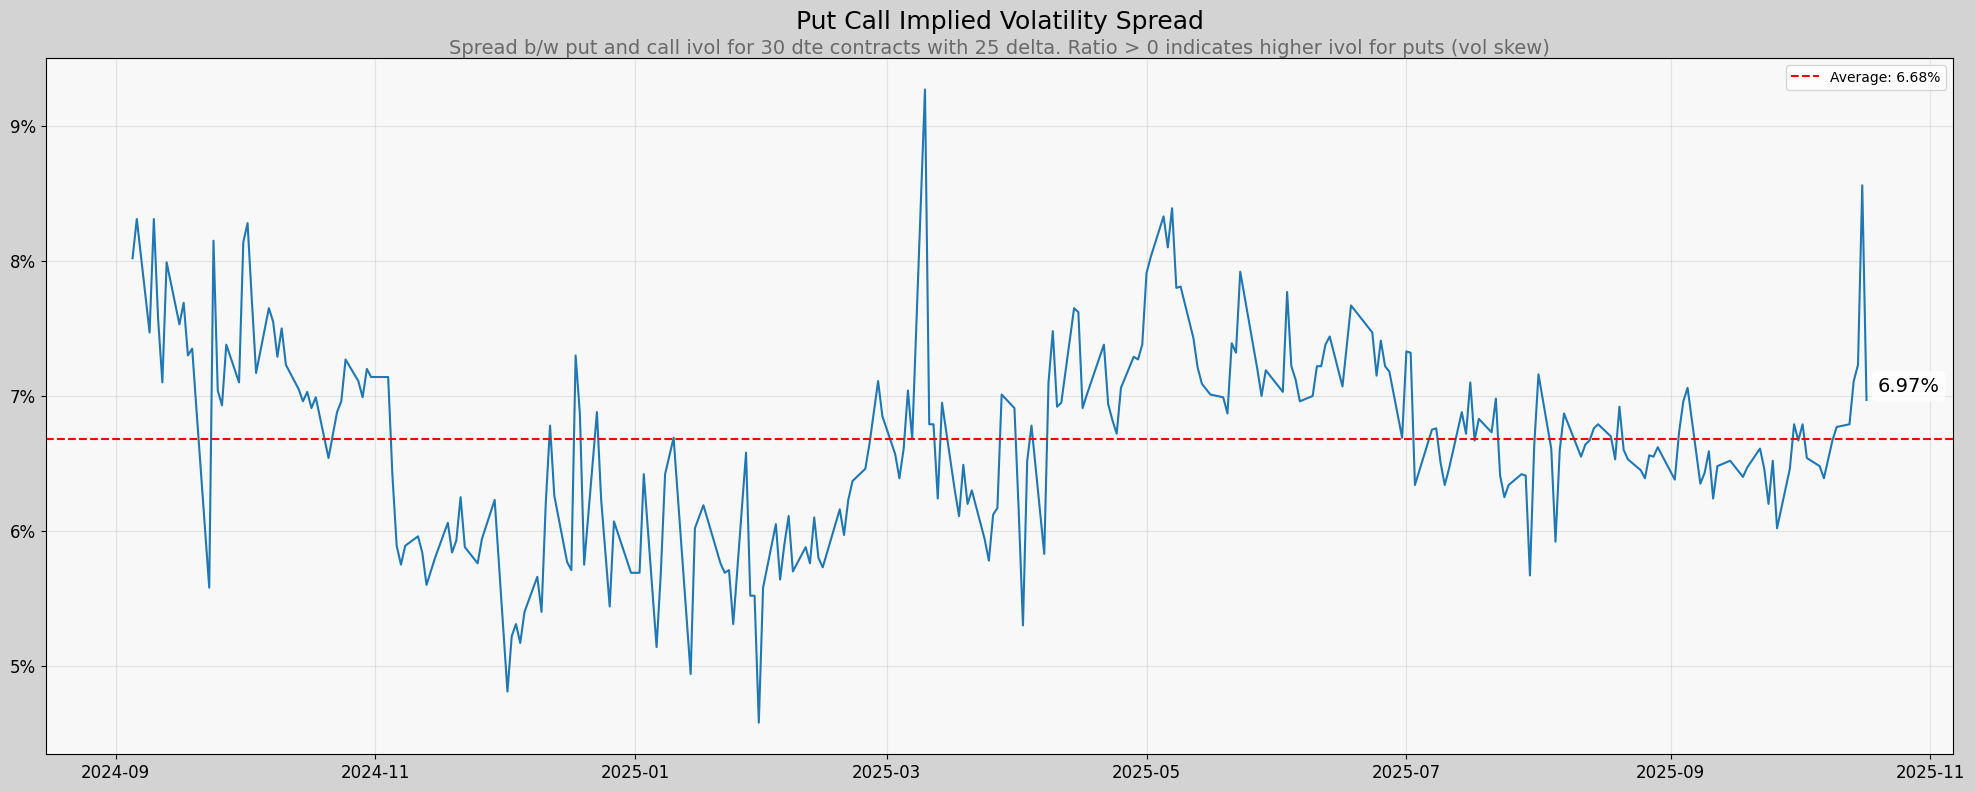

In [70]:
ax = plot.plot_line(
    x=pcs['tradetime'],
    y=pcs['pc_spread'],
    date_axis=False,
    style=cs,
    title="Put Call Implied Volatility Spread",
    subtitle="Spread b/w put and call ivol for 30 dte contracts with 25 delta. Ratio > 0 indicates higher ivol for puts (vol skew)",
    style_kwargs = {"subtitle_size": 14},
    grid=True,
    annotate_last=True,
    annotate_last_fmt="{:.2%}",
    y_fmt="{:,.0%}",
    legend=True
)
ax.axhline(pcs['pc_spread'].mean(), color='red', linestyle='--', label=f'Average: {pcs["pc_spread"].mean():.2%}')
plt.legend()

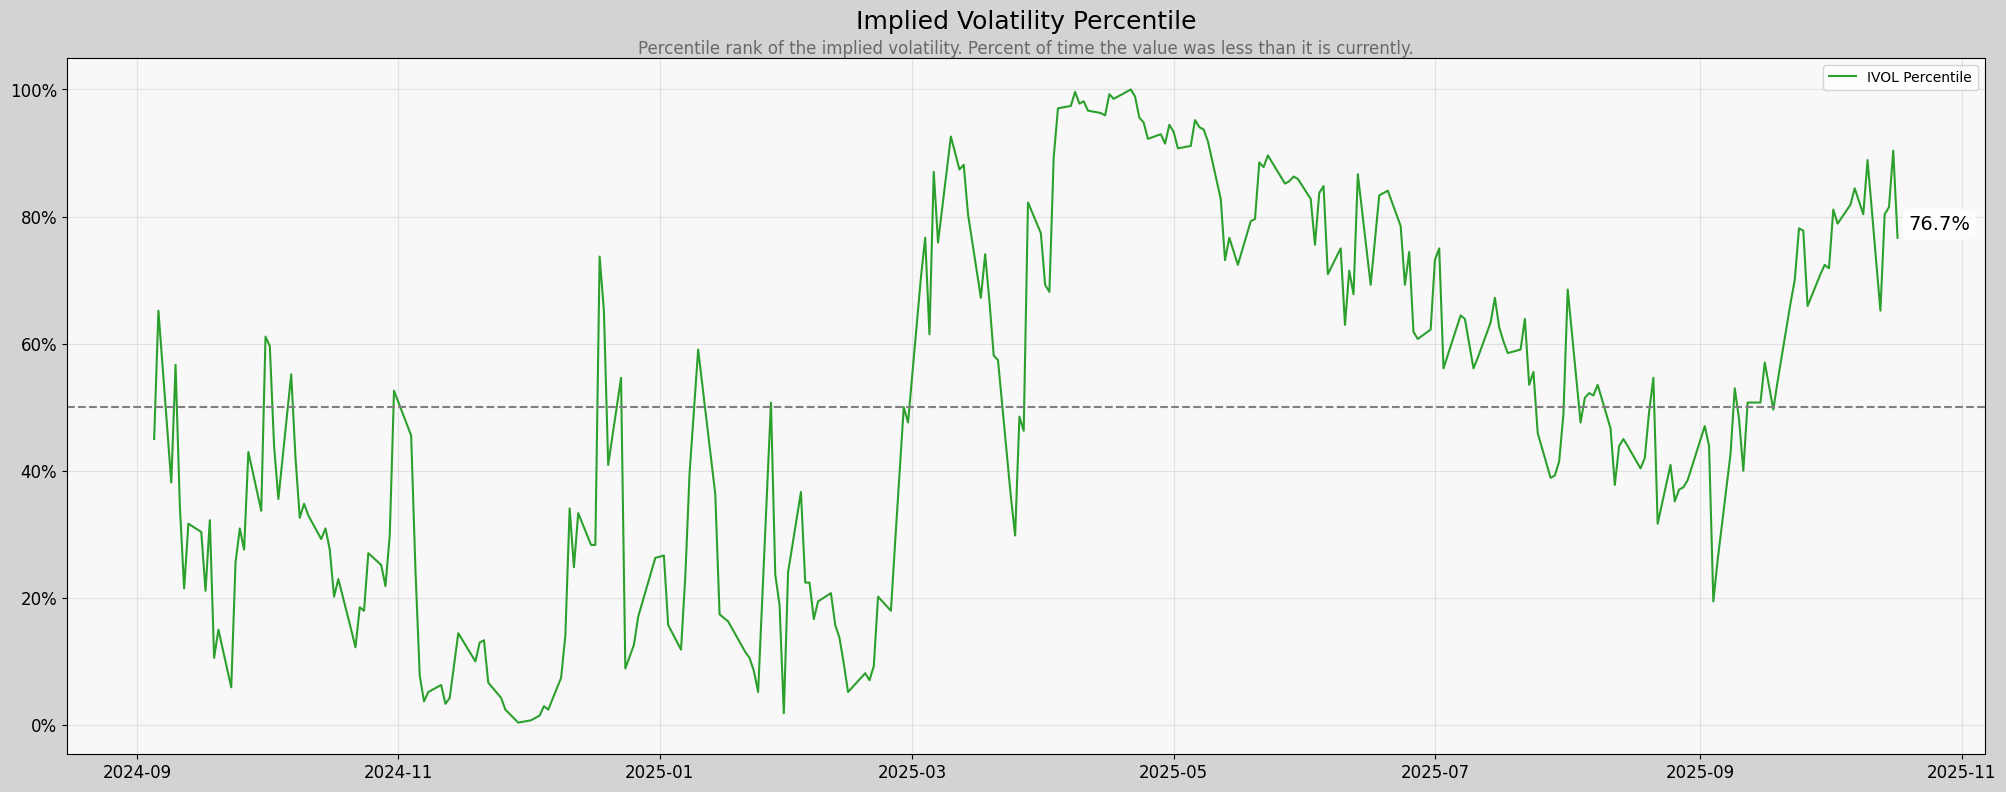

In [71]:
ax = plot.plot_line(
    x=ivol_rank['tradetime'],
    y=ivol_rank['ivol_percentile'],
    date_axis=False,
    style=cs,
    title="Implied Volatility Percentile",
    subtitle="Percentile rank of the implied volatility. Percent of time the value was less than it is currently.",
    style_kwargs={"subtitle_size": 12},
    grid=True,
    label="IVOL Percentile",
    annotate_last=True,
    annotate_last_fmt="{:.1%}",
    y_fmt="{:.0%}",
    color="tab:green",
)
ax.axhline(y=.5, color='gray', linestyle='--', )
ax.legend()

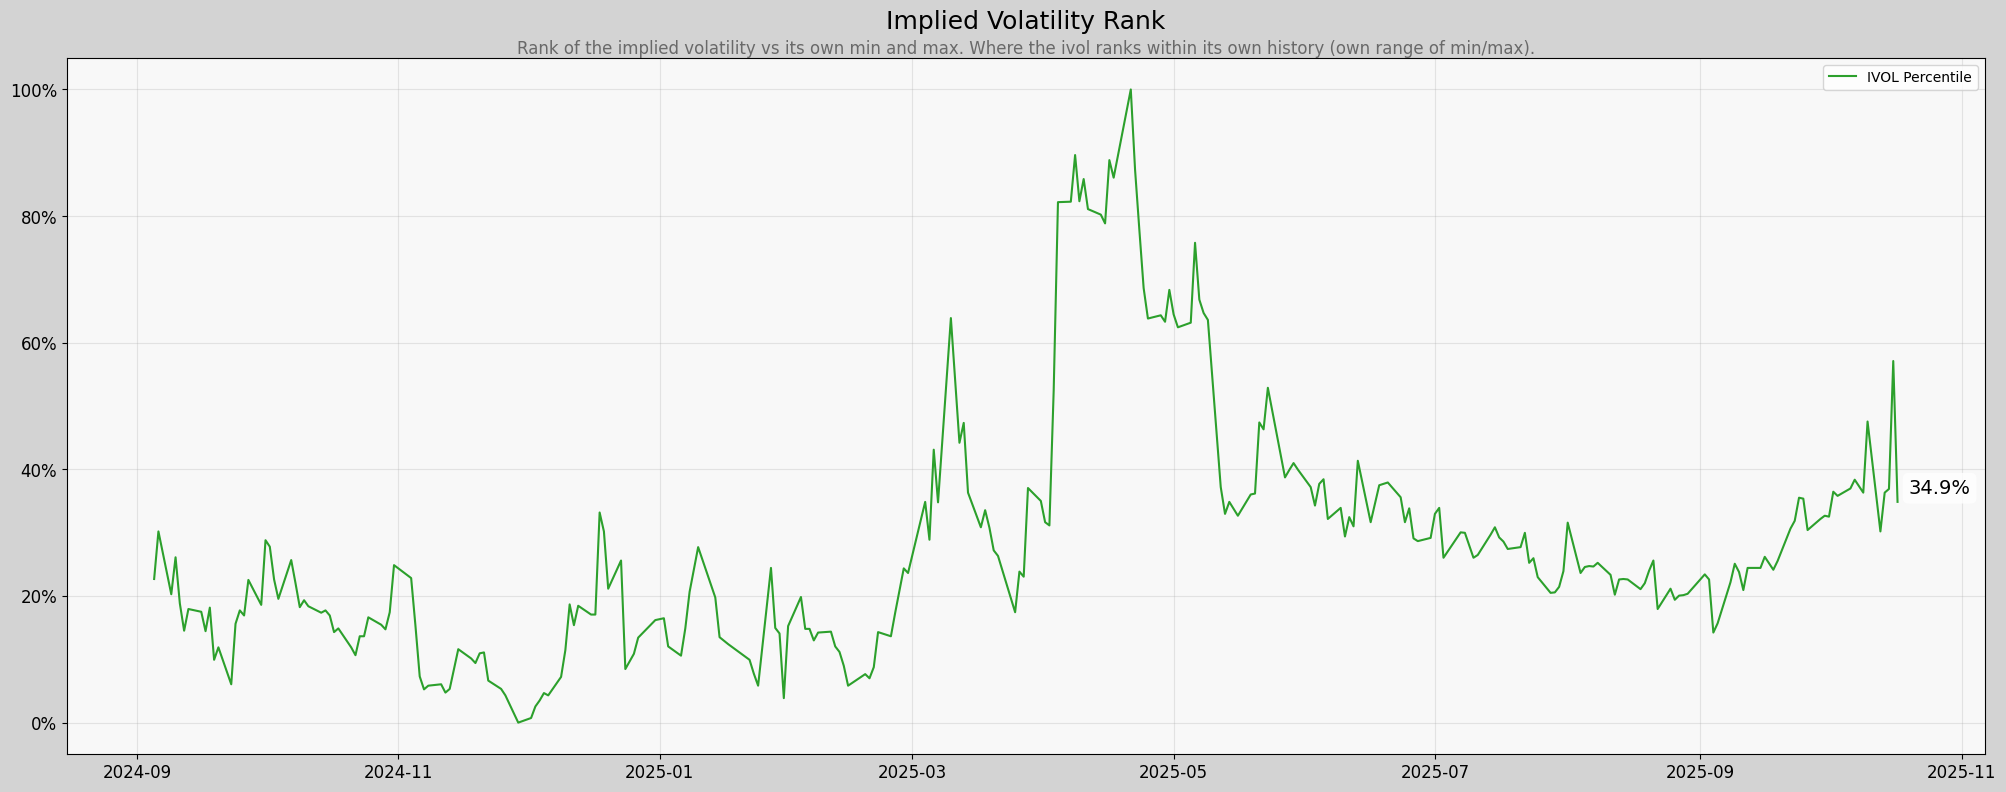

In [72]:
ax = plot.plot_line(
    x=ivol_rank['tradetime'],
    y=ivol_rank['ivol_rank'],
    date_axis=False,
    style=cs,
    title="Implied Volatility Rank",
    subtitle="Rank of the implied volatility vs its own min and max. Where the ivol ranks within its own history (own range of min/max).",
    style_kwargs={"subtitle_size": 12},
    grid=True,
    label="IVOL Percentile",
    annotate_last=True,
    annotate_last_fmt="{:.1%}",
    y_fmt="{:.0%}",
    color="tab:green",
)
ax.legend()

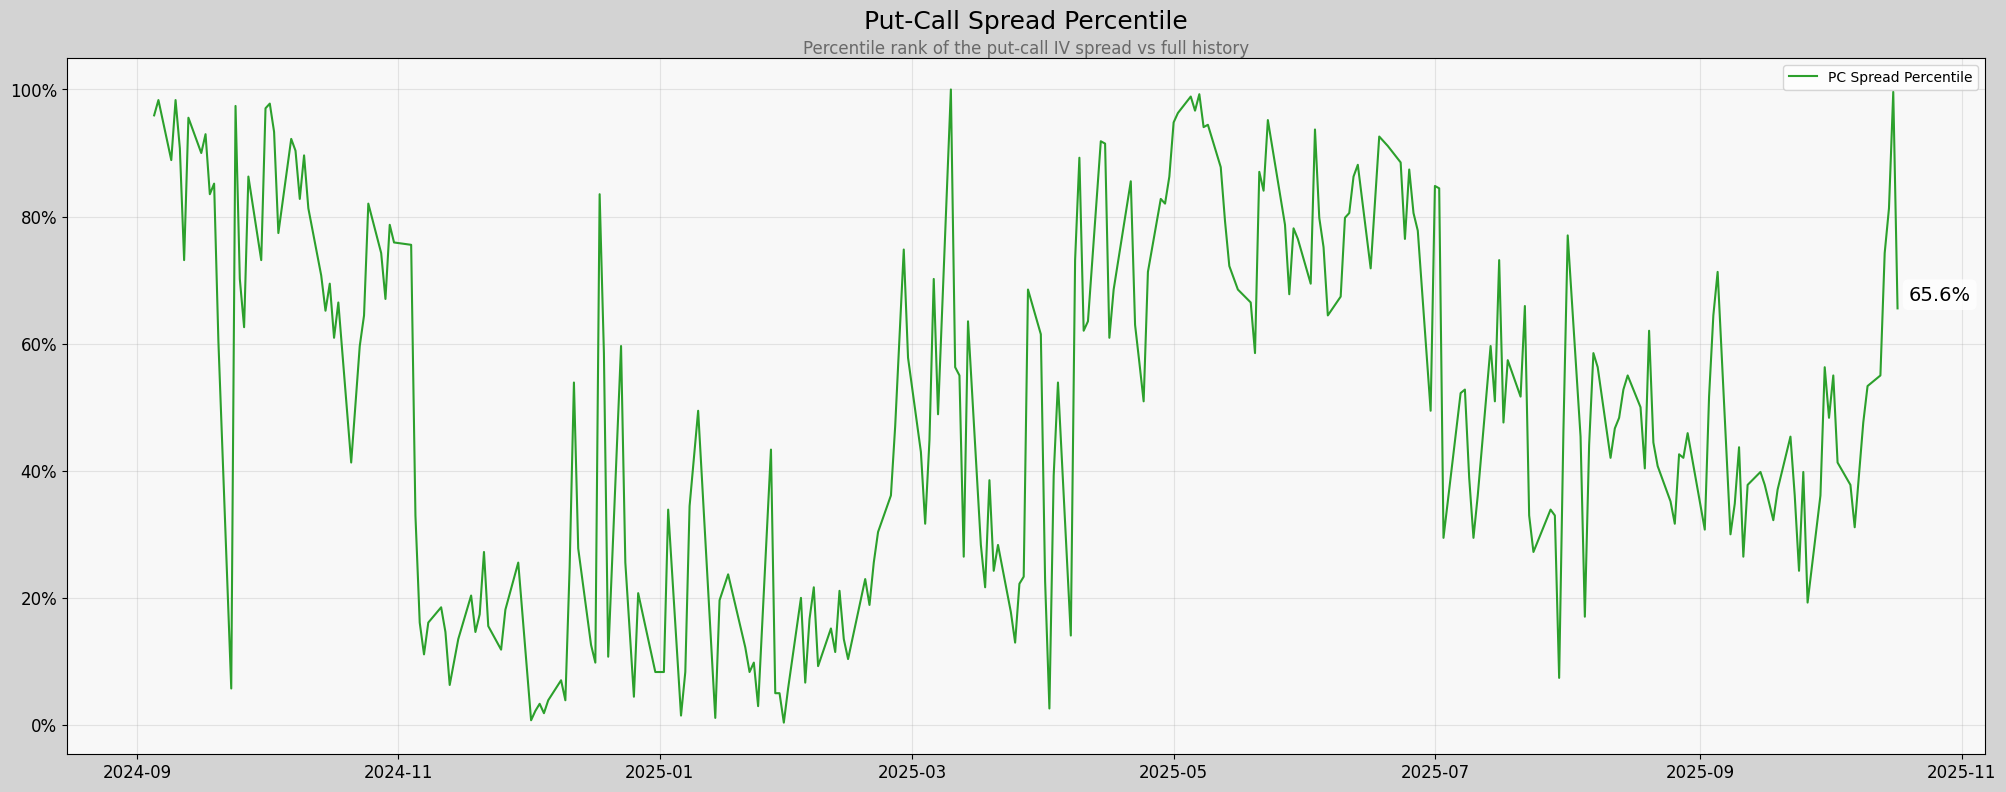

In [73]:
ax = plot.plot_line(
    x=pcs_rank['tradetime'],
    y=pcs_rank['pc_spread_percentile'],
    date_axis=False,
    style=cs,
    title="Put-Call Spread Percentile",
    subtitle="Percentile rank of the put-call IV spread vs full history",
    style_kwargs={"subtitle_size": 12},
    grid=True,
    label="PC Spread Percentile",
    annotate_last=True,
    annotate_last_fmt="{:.1%}",
    y_fmt="{:.0%}",
    color="tab:green",
)
ax.legend()

In [74]:
# implied_move_ts = ch.get_implied_move_timeseries()

# res = implied_move_ts[implied_move_ts['exp_date']=='2025-12-19']

# ax = plot.plot_line(
#     x=res['tradetime'],
#     y=res['expected_move_pct'],
#     date_axis=False,
#     style=cs,
#     title="Implied Move in Underlying",
#     subtitle="",
#     style_kwargs={"subtitle_size": 12},
#     grid=True,
#     label="% Change",
#     annotate_last=True,
#     annotate_last_fmt="{:.1%}",
#     y_fmt="{:.0%}",
#     color="tab:green",
# )
# ax.legend()

display(ch.get_implied_move_latest())

type,tradetime,exp_date,dte,call,put,ivol,undr_last_price,expected_move_usd,expected_move_pct
0,2024-11-21,2025-12-19,393.0,0.1493,0.1495,0.14940,664.39,102.996752,0.155025
1,2024-12-06,2026-01-16,405.0,0.1514,0.1432,0.14730,664.39,103.087715,0.155161
2,2025-10-17,2026-01-30,104.0,NaN,0.1592,NaN,664.39,NaN,NaN
3,2025-10-15,2026-02-20,128.0,0.1675,NaN,NaN,664.39,NaN,NaN
4,2025-10-10,2026-02-27,139.0,NaN,0.1678,NaN,664.39,NaN,NaN
5,2025-03-31,2026-03-20,354.0,0.1731,0.1732,0.17315,664.39,113.292401,0.170521
6,2025-10-15,2026-03-31,167.0,0.1927,0.1638,0.17825,664.39,80.105886,0.120571
7,2025-06-18,2026-06-18,365.0,0.1646,0.1675,0.16605,664.39,110.321960,0.166050
8,2025-10-16,2026-06-30,257.0,0.1762,NaN,NaN,664.39,NaN,NaN
9,2025-10-17,2026-09-18,335.0,0.1749,0.1576,0.16625,664.39,105.818283,0.159271


# Evaluate Chain (Strategies)

In [ ]:
chain = Chain(ticker = 'SPY', max_expiration="2026-01-31")
calls = chain.calls
puts = chain.puts
atm = chain.atm    
atm_calls = chain.atm_calls
atm_puts = chain.atm_puts

Total records to fetch: 1730
Fetched 1000 rows at offset 0
Fetched 730 rows at offset 1000


array(['2025-10-20', '2025-10-21', '2025-10-22', '2025-10-23',
       '2025-10-24', '2025-10-27', '2025-10-28', '2025-10-29',
       '2025-10-30', '2025-10-31', '2025-11-07', '2025-11-14',
       '2025-11-21', '2025-11-28', '2025-12-19', '2025-12-31',
       '2026-01-16', '2026-01-30'], dtype=object)